# Lab Assignment 6: Anomaly Detection

This lab assignment consists of two exercises which, together, demonstrate the tuning of an observer for the purpose of state and disturbance estimation. The disturbance is a proxy for any variable or modeling that may affect the operation of the Temperature Control Lab. Monitoring the disturbance estimate provides a means for detecting operational anomalies.

In [14]:
# standard imports

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from tclab import setup, Historian, Plotter, clock

## Part 1. Determing the Observer Gains $L$

### State Space Model

The state-space model for the Temperature Control Laboratory was previously developed and included here for reference.

\begin{align}
\frac{d}{dt}\underbrace{\left[\begin{array}{c} T_{H,1} \\ T_{S,1} \\ T_{H,2} \\ T_{S,2} \end{array}\right]}_x
& = 
\underbrace{\left[\begin{array}{cccc}
-(\frac{U_a+U_b+U_c}{C^H_p}) & \frac{U_b}{C^H_p} & \frac{U_c}{C^H_p} & 0 \\
\frac{U_b}{C^S_p} & -\frac{U_b}{C^S_p} & 0 & 0 \\
\frac{U_c}{C^H_p} & 0 & -(\frac{U_a+U_b+U_c}{C^H_p}) & \frac{U_b}{C^H_p} \\
0 & 0 & \frac{U_b}{C^S_p} & -\frac{U_b}{C^S_p}
\end{array}\right]}_A
\underbrace{\left[\begin{array}{c}T_{H,1} \\ T_{S,1} \\ T_{H,2} \\ T_{S,2}\end{array}\right]}_x
+
\underbrace{\left[\begin{array}{cc}\frac{\alpha P_1}{C_p} & 0 \\ 0 & 0 \\ 0 & \frac{\alpha P_2}{C_p} \\ 0 & 0 \end{array}\right]}_{B_u}
\underbrace{\left[\begin{array}{c}u_1 \\ u_2\end{array}\right]}_u
+
\underbrace{\left[\begin{array}{c}\frac{U_a}{C^H_p} \\ 0 \\ \frac{U_a}{C^H_p} \\ 0 \end{array}\right]}_{B_d}
\underbrace{\left[\begin{array}{c}T_{amb}\end{array}\right]}_{d}
\end{align}

\begin{align}
\underbrace{\left[\begin{array}{c} T_1 \\ T_2 \end{array}\right]}_y
& = 
\underbrace{\left[\begin{array}{cccc} 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \end{array}\right]}_C
\underbrace{\left[\begin{array}{c}T_{H,1} \\ T_{S,1} \\ T_{H,2} \\ T_{S,2}\end{array}\right]}_x
\end{align}

where

\begin{align}
\frac{dx}{dt} & = A x + B_u u + B_d d \\
y & = C x
\end{align}

The process variables are gathered and organized into the state vector $x$, manipulable inputs $u$, disturbance inputs $d$, and measured process variables $y$.

$$x = \left[\begin{array}{c}T_{H,1} \\ T_{S,1} \\ T_{H,2} \\ T_{S,2}\end{array}\right]
\qquad
u = \left[\begin{array}{c}u_1 \\ u_2\end{array}\right]
\qquad
d = \left[\begin{array}{c}T_{amb}\end{array}\right]
\qquad
y = \left[\begin{array}{c} T_1 \\ T_2 \end{array}\right]
$$

Coefficients are organized into matrices $A$, $B_u$, $B_d$ and $C$.

$$
A = \left[\begin{array}{cccc}
-(\frac{U_a+U_b+U_c}{C^H_p}) & \frac{U_b}{C^H_p} & \frac{U_c}{C^H_p} & 0 \\
\frac{U_b}{C^S_p} & -\frac{U_b}{C^S_p} & 0 & 0 \\
\frac{U_c}{C^H_p} & 0 & -(\frac{U_a+U_b+U_c}{C^H_p}) & \frac{U_b}{C^H_p} \\
0 & 0 & \frac{U_b}{C^S_p} & -\frac{U_b}{C^S_p}
\end{array}\right]
$$

$$
B_u = \left[\begin{array}{cc}\frac{\alpha P_1}{C_p} & 0 \\ 0 & 0 \\ 0 & \frac{\alpha P_2}{C_p} \\ 0 & 0 \end{array}\right]
\qquad
B_d  = \left[\begin{array}{c}\frac{U_a}{C^H_p} \\ 0 \\ \frac{U_a}{C^H_p} \\ 0 \end{array}\right]
$$

$$
C = \left[\begin{array}{cccc} 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \end{array}\right]
$$


In [15]:
# parameter estimates.
alpha = 0.00016       # watts / (units P * percent U1)
P1 = 200              # P units
P2 = 100              # P units
CpH = 4.46            # heat capacity of the heater (J/deg C)
CpS = 0.819           # heat capacity of the sensor (J/deg C)
Ua = 0.050            # heat transfer coefficient from heater to environment
Ub = 0.021            # heat transfer coefficient from heater to sensor
Uc = 0.0335           # heat transfer coefficient between heaters
Tamb = 21             # ambient room temperature

# state space model
A = np.array([[-(Ua + Ub + Uc)/CpH, Ub/CpH, Uc/CpH, 0], 
              [Ub/CpS, -Ub/CpS, 0, 0],
              [Uc/CpH, 0, -(Ua + Ub + Uc)/CpH, Ub/CpH],
              [0, 0, Ub/CpS, -Ub/CpS]])

Bu = np.array([[alpha*P1/CpH, 0], [0, 0], [0, alpha*P2/CpH], [0, 0]])

Bd = np.array([[Ua/CpH], [0], [Ua/CpH], [0]])

C = np.array([[0, 1, 0, 0], [0, 0, 0, 1]])

# initial values for states and inputs
u_initial = np.array([0, 0])
d_initial = np.array([Tamb])
x_initial = np.array([Tamb, Tamb, Tamb, Tamb])

### Observer

At each time step $t_k$ there are two calculations to perform:

* **Model Prediction:** Use the model to update the state to the next time step, i.e., $\hat{x}_{k-1} \rightarrow \hat{x}_{k}^{pred}$ with the equation

\begin{align}
\hat{x}_k^{pred} & = \hat{x}_{k-1} + (t_k - t_{k-1}) ( A \hat{x}_{k-1} + B_u u_{k-1} + B_d \hat{d}_{k-1}) \\
\hat{y}_k^{pred} & = C \hat{x}_k^{pred}
\end{align}

* **Measurement Correction:** Use measurement $y_k$ to update $\hat{x}_{k}^{pred} \rightarrow \hat{x}_{k}$ with the equation

$$\hat{x}_{k} = \hat{x}_{k}^{pred} - (t_k - t_{k-1})L (\underbrace{\hat{y}_{k}^{pred} - y_k}_{y_k^{err}})$$ 

The following cell presents an implementation of an observer for the Temperature Control Lab. This version of the observer assumes $\hat{d}_{k} = \hat{d}$ is constant in time.

In [16]:
def tclab_observer(L, x_initial, d_hat):
    
    # initialize
    t = 0
    x_hat = x_initial
    y_err = None

    while True:
        # save previous time value
        t_prev = t
        
        # yield current state and measurement error.
        # wait for message with next time, last control input, and measurement
        t, u, y = yield x_hat, y_err
        
        # update model prediction
        x_pred = x_hat + (t - t_prev)*(np.dot(A, x_hat) + np.dot(Bu, u) + np.dot(Bd, d_hat))
        y_pred = np.dot(C, x_pred)
        
        # measurement correction
        y_err = y_pred - y
        x_hat = x_pred - (t - t_prev)*np.dot(L, y_err)

### Testing the Observer

In [17]:
def experiment(observer, u1, u2, t_final=400, t_step=2, connected=False):
    
    if not connected:
        TCLab = setup(connected=False, speedup=20)
        
    with TCLab() as lab:
        
        # setup historian
        sources = [('T1', lambda: y[0]), 
                   ('T2', lambda: y[1]), 
                   ('Q1', lambda: u[0]), 
                   ('Q2', lambda: u[1]),
                   ('Th1', lambda: x[0]), 
                   ('Ts1', lambda: x[1]), 
                   ('Th2', lambda: x[2]), 
                   ('Ts2', lambda: x[3]),
                   ('y_err_1', lambda: y_err[0]),
                   ('y_err_2', lambda: y_err[1]),
        ]
        h = Historian(sources)
        
        layout = [['Th1', 'Th2'], ['T1', 'Ts1', 'T2', 'Ts2'], ['y_err_1', 'y_err_2'], ['Q1', 'Q2']]
        p = Plotter(h, t_final, layout)
            
        # initialize event loop
        next(observer)
        u = [lab.Q1(u1(0)), lab.Q2(u2(0))]

        for t in clock(t_final, t_step):
            # get new measurement
            y = [lab.T1, lab.T2]
            x, y_err = observer.send([t, u, y])

            # update plotter and historian
            p.update(t)

            # set input for next period
            u = [lab.Q1(u1(t)), lab.Q2(u2(t))]
            
    return h

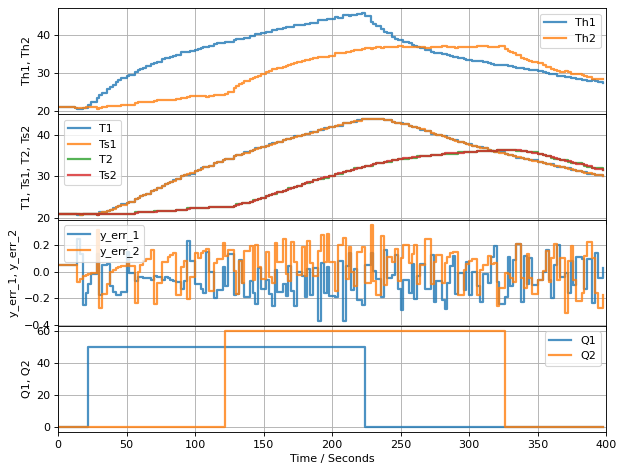

TCLab Model disconnected successfully.


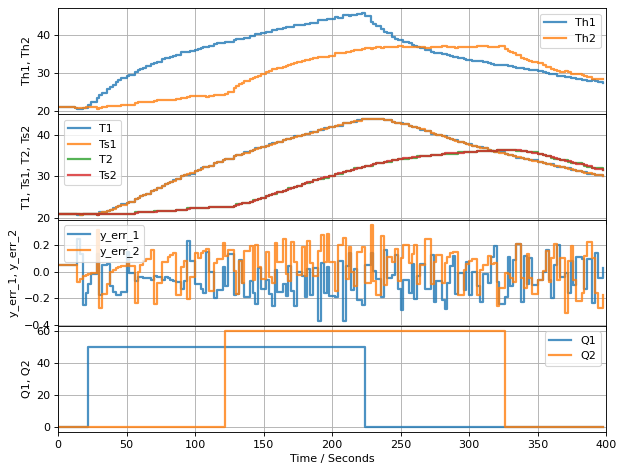

In [30]:
def u1(t):
    return 50 if 20 <= t <= 220 else 0

def u2(t):
    return 60 if 120 <= t <= 320 else 0

L = np.array([[0.4, 0], [0.2, 0], [0, 0.4], [0, 0.2]])

observer = tclab_observer(L, x_initial, d_initial)
experiment(observer, u1, u2)

### Eigenvalues and Eigenvectors

For a linear system with dynamics governed by a constant coefficient matrix $A$, the eigenvalues of $A$ determine stability. A system is asymptotically stable if all of the eigenvalues have negative real part. Here we demonstrate the calculation and display of the eigenvalues for the model governing the Temperature Control Lab which has all real eigenvalues.

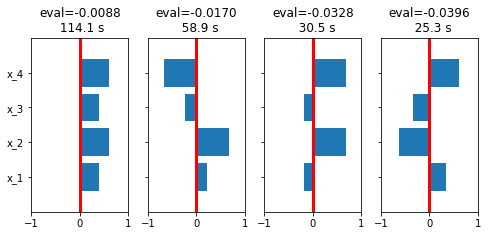

In [6]:
eigenvalues, eigenvectors = np.linalg.eig(A)

eigenmodes = [mode for mode in sorted(zip(eigenvalues, eigenvectors.T))]
n = len(eigenmodes)
fig, ax = plt.subplots(1, n, figsize=(2*n, 0.8*n), sharey=True)
for k, mode in enumerate(sorted(eigenmodes, key=lambda v: -v[0])):
    eval, evec = mode
    evec = evec/max(evec, key=abs)
    evec = evec/np.linalg.norm(evec)
    ax[k].barh(range(n), evec)
    ax[k].set_yticks(range(n))
    ax[k].set_yticklabels([f"x_{k}" for k in range(1, n+1)])
    ax[k].set_xlim(-1, 1)
    ax[k].plot([0, 0], [-1, n], 'r', lw=3)
    ax[k].set_ylim(-1, n)
    ax[k].set_title(f"eval={eval:6.4f}\n{-1/eval: 6.1f} s")

### Placing the eigenvalues of $A-LC$

As has been previously demonstrated, the dynamics of the state error $e = \hat{x} - x$ are described by the equation

$$\frac{de}{dt} = (A - LC) e + B_d (\hat{d} - d)$$

The coefficient matrix $A - LC$, where we get to choose $L$, determines the evolution of the error in the state estimate. We would like for the error to decay quickly to a minimal value which implies choosing $L$ so that eigenvalues of $A - LC$ are negatives values.

Let's compare the eigenvalues of $A$ to the eigenvalues of $A-LC$ using the $L$ found in the example above.

In [7]:
evals, evecs = np.linalg.eig(A)
evals

array([-0.00876519, -0.01698846, -0.03959427, -0.03279512])

In [8]:
L = np.array([[0.4, 0], [0.2, 0], [0, 0.4], [0, 0.2]])

evals, _ = np.linalg.eig(A - np.dot(L, C))
evals

array([-0.09145229+0.j        , -0.12829136+0.02566559j,
       -0.12829136-0.02566559j, -0.15010801+0.j        ])

**Pole placement** describes a family of algorithms which, given $A$, $C$, and a desired set of eigenvalues, computes a matrix $L$ such that $A-LC$ has the specified set of eigenvalue, or else reports that no such $L$ exists. The following cell shows how to use `scipy.signal.place_poles()` to compute an $L$ where the eigenvalues are 3 times larger (i.e, more negative) than the eigenvalues of $A$ alone.

In [9]:
from scipy.signal import place_poles

evals, _ = np.linalg.eig(A)

results = place_poles(A.T, C.T, 3*evals)
L = results.gain_matrix.T

print(L)

[[ 0.05695624 -0.01773553]
 [ 0.0990523  -0.01497065]
 [-0.01744486  0.05443456]
 [-0.01502702  0.09723378]]


What is notable about this version of $L$ is that we are now using both sensors to update every estimated state.

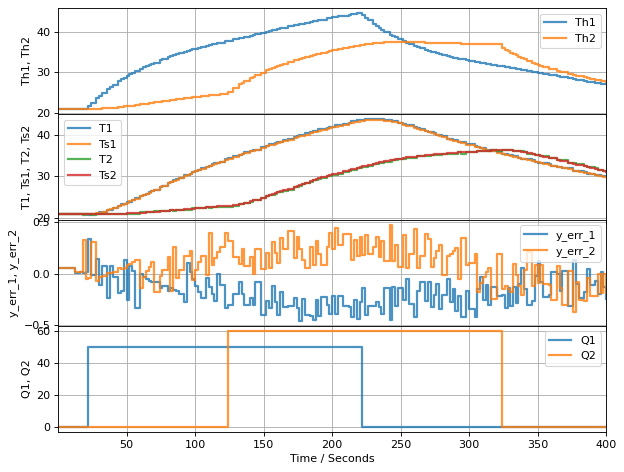

TCLab Model disconnected successfully.


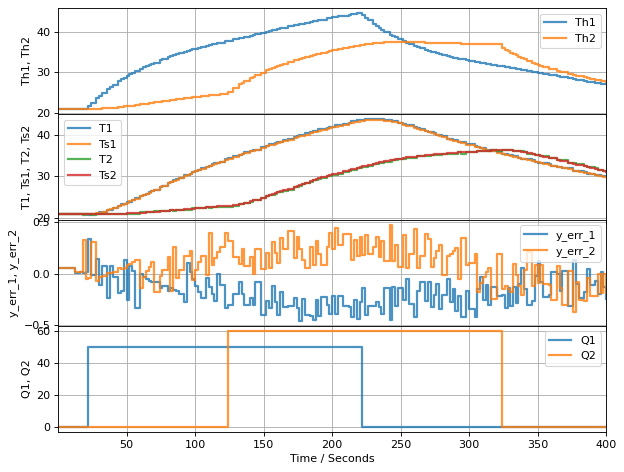

In [10]:
def u1(t):
    return 50 if 20 <= t <= 220 else 0

def u2(t):
    return 60 if 120 <= t <= 320 else 0

observer = tclab_observer(L, x_initial, d_initial)
experiment(observer, u1, u2)

### Exercise 1.

Test the observer described above for your device. Perform the following calculations:

1. Revise the parameters and coefficient matrices $A$, $B_u$, $B_d$ to incorporate the best estimates available for your particular device.

2. Compute $L$ where the eigenvalues are placed multiples of 1, 2, 5, and 10 times the eigenvalues of $A$ alone. Test each $L$ using your particular device.

3. Report the results of each experimental run for your device. Which of these $L$ matrices would you recommend for production use? Why?

## Part 2. Estimating Disturbances

Our model for the Temperature Control Lab is given by

\begin{align}
\frac{dx}{dt} & = A x + B_u u + B_d d \\
y & = C x
\end{align}

where $d$ is an unmeasured disturbance. Up to this point we have used an apriori constant estimate $\hat{d}$ for real-time control calculations. Here we show how, in principle, $d$ can be estimated in real-time.

We assume $d$ is constant or changing so slowly in time that the dynamics can be modeled by

$$\frac{dd}{dt} = w_d$$

where $w_d$ is a external signal causiing changes in $d$. This additional model equation can be incorporated into the state space framework.

\begin{align}
\begin{bmatrix}\frac{dx}{dt} \\ \frac{dd}{dt} \end{bmatrix} & = \underbrace{\begin{bmatrix} A & B_d \\ 0 & 0 \end{bmatrix}}_{A^{aug}} \underbrace{\begin{bmatrix}x \\ d \end{bmatrix}}_{x^{aug}} + \underbrace{\begin{bmatrix}B_u \\ 0 \end{bmatrix}}_{B_u^{aug}} u + \underbrace{\begin{bmatrix} 0 \\ 1\end{bmatrix}}_{B_d^{aug}} w_d\\
y & = \underbrace{\begin{bmatrix}C & 0 \end{bmatrix}}_{C^{aug}} \begin{bmatrix}x \\ d \end{bmatrix}
\end{align}



In [32]:
from scipy.signal import place_poles

A_aug = np.vstack([np.hstack([A, Bd]), np.zeros([1, 5])])
Bu_aug = np.vstack([Bu, [[0, 0]]])
Bd_aug = np.vstack([np.zeros([4, 1]), [[1]]])
C_aug = np.hstack([C, np.zeros([2, 1])])

evals, _ = np.linalg.eig(A)
results = place_poles(A_aug.T, C_aug.T, np.hstack([3*evals, min(evals)]))
L_aug = results.gain_matrix.T
print(L_aug)

[[0.16514296 0.13790439]
 [0.11789634 0.03657137]
 [0.13768607 0.16538229]
 [0.03651512 0.117984  ]
 [0.27664269 0.2771419 ]]


In [12]:
np.linalg.eig(A_aug)[0]

array([-0.00876519, -0.01698846, -0.03959427, -0.03279512,  0.        ])

In [13]:
np.linalg.eig(A)[0]

array([-0.00876519, -0.01698846, -0.03959427, -0.03279512])

### Testing Disturbance Estimator

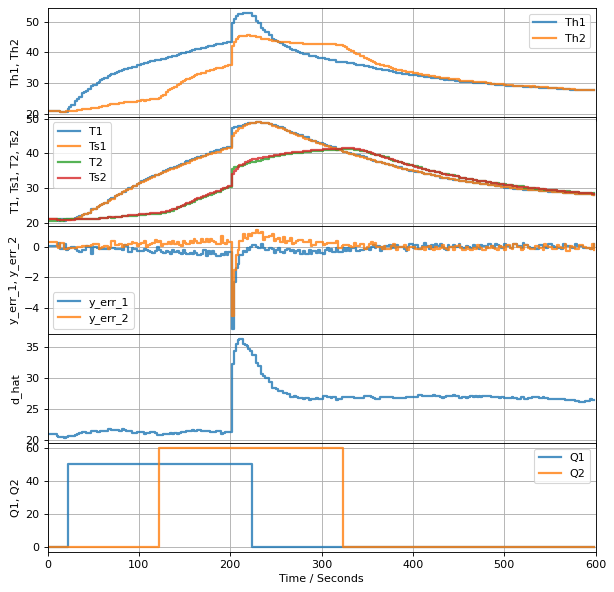

TCLab Model disconnected successfully.


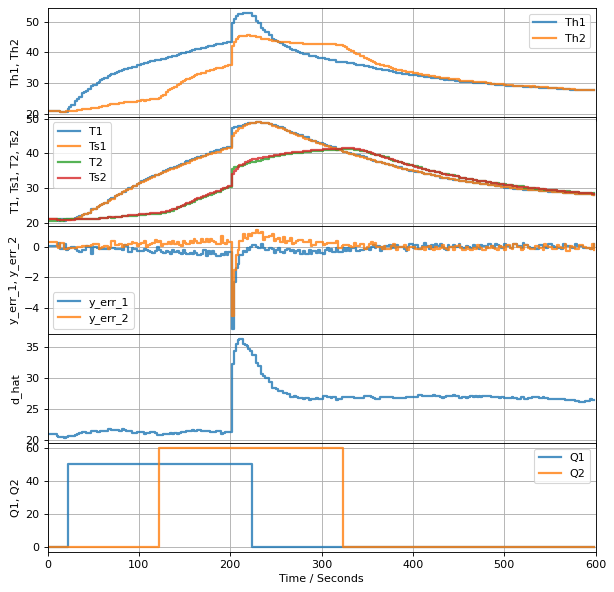

In [33]:
def tclab_observer_disturbance(L_aug, x_initial, d_hat):
    
    # initialize
    x_hat = np.hstack([x_initial, d_hat])
    print(x_hat)
    t = 0
    y_err = None

    while True:
        # save previous time value
        t_prev = t
        
        # yield current state and measurement error.
        # wait for message with next time, last control input, and measurement
        t, u, y = yield x_hat, y_err
        
        # model prediction
        x_pred = x_hat + (t - t_prev)*(np.dot(A_aug, x_hat) + np.dot(Bu_aug, u))
        y_pred = np.dot(C_aug, x_pred)
        
        # measurement correction
        y_err = y_pred - y
        x_hat = x_pred - (t - t_prev)*np.dot(L_aug, y_err)
                       
                       
def experiment_disturbance(observer, u1, u2, t_final=400, t_step=2):
    
    # open connection to tclab
    TCLab = setup(connected=False, speedup=20)
    with TCLab() as lab:
        
        # setup historian
        sources = [('T1', lambda: y[0]), 
                   ('T2', lambda: y[1]), 
                   ('Q1', lambda: u[0]), 
                   ('Q2', lambda: u[1]),
                   ('Th1', lambda: x[0]), 
                   ('Ts1', lambda: x[1]), 
                   ('Th2', lambda: x[2]), 
                   ('Ts2', lambda: x[3]),
                   ('d_hat', lambda: x[4]),
                   ('y_err_1', lambda: y_err[0]),
                   ('y_err_2', lambda: y_err[1]),
        ]
        h = Historian(sources)
        
        layout = [['Th1', 'Th2'], ['T1', 'Ts1', 'T2', 'Ts2'], ['y_err_1', 'y_err_2'], ['d_hat'], ['Q1', 'Q2']]
        p = Plotter(h, t_final, layout)
            
        # initialize event loop
        next(observer)
        u = [lab.Q1(u1(0)), lab.Q2(u2(0))]

        for t in clock(t_final, t_step):
            # get new measurement
            y = [lab.T1 + d(t), lab.T2 + d(t)]
            x, y_err = observer.send([t, u, y])

            # update plotter and historian
            p.update(t)

            # set input for next period
            u = [lab.Q1(u1(t)), lab.Q2(u2(t))]
            
    return h

def d(t):
    return 0 if t <= 200 else 5

observer = tclab_observer_disturbance(L_aug, x_initial, d_initial)
experiment_disturbance(observer, u1, u2, t_final=600)

### Exercise 2.

Implement a disturbance estimator for your copy of the Temperature Control Lab. 

1. Using the matrix parameters used for Exercise 1 of this assignment, compute and report numerical values for augmented matrices $A_{aug}$, $B_{aug}$, $C_{aug}$ described above.

2. Using the results of exercise 1, choose an initial value for $L_{aug}$. Place four of the eigenvalues to match the eigenvalues placed in exercise 1.  The fifth eigenvalue should have a negative value corresponding to a time constant chosen to between 20 and 100 seconds. Test your code as shown above.

3. Test your disturbance estimator on your copy of the Temperature Control Lab. You will need to adapt the testing code presented above for this purpose. Try to detect changes in the environment surrounding your device, such placing in cooler, warmer, or breezy place. A hair dryer would certainly do the job. Does your disturbance estimator detect the change?  If needed, choose a different time constant in part 2. 